<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><strong>Описание данных</strong></a></span></li><li><span><a href="#Общая-информация" data-toc-modified-id="Общая-информация-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><strong>Общая информация</strong></a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><strong>Исследовательский анализ данных</strong></a></span><ul class="toc-item"><li><span><a href="#Баланс-классов" data-toc-modified-id="Баланс-классов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Баланс классов</a></span></li><li><span><a href="#Количество-символов-в-текстах" data-toc-modified-id="Количество-символов-в-текстах-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Количество символов в текстах</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><strong>Подготовка данных</strong></a></span><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Разбиение-на-тестовую-и-тренировочную-выборки" data-toc-modified-id="Разбиение-на-тестовую-и-тренировочную-выборки-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Разбиение на тестовую и тренировочную выборки</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span><strong>Обучение модели</strong></a></span><ul class="toc-item"><li><span><a href="#Анализ-важности-признаков." data-toc-modified-id="Анализ-важности-признаков.-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Анализ важности признаков.</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span><strong>Итоговые выводы</strong></a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект: Машинное обучение для текстов

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 


**Цель исследования:**
1. Обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75.

**Ход исследования**

Данные получим из файла `/datasets/toxic_comments.csv`, 

просмотрим общую информацию о датасете, оценим качество данных.

Далее приступим к подготовке данных: лемматизируем текст, добавим новые столбцы. 

После этого применим пайплайн для подготовки признаков и обучения моделей.

Завершающим этапом исследования будет выбор лучшей модели и проверка на тестовой выборке.

Таким образом, иследование будет состоять из следующих этапов:

- [Обзор данных](#info)

- [Исследовательский анализ данных](#EDA)

- [Подготовка данных](#preprocessing)

- [Обучение модели](#model)

- [Итоговые выводы](#final)

## **Описание данных**

Данные находятся в файле `toxic_comments.csv`. 

Столбец **text** в нём содержит текст комментария, а **toxic** — целевой признак.

In [1]:
# Устанавливаем и обновляем необходимые библиотеки
!pip install -Uq scikit-learn scikit-optimize

In [2]:
# Импротируем необходимые библиотеки
import os
import re
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
sns.set()


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, TunedThresholdClassifierCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline


# Зафиксируем случайность  и размер тестовой выборки
RANDOM_STATE = 42
TEST_SIZE = 0.5
state = RandomState(12345)

sklearn.__version__


'1.6.1'

## **Общая информация**
<a id='info'></a>

In [3]:
# Загружаем файл
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'
    
if os.path.exists(pth1):
    comments = pd.read_csv(pth1, index_col=0).reset_index(drop=True)
elif os.path.exists(pth2):
    comments = pd.read_csv(pth2, index_col=0).reset_index(drop=True)
else:
    print('Something is wrong')

In [4]:
# Посмотрим на первые 5 строк датасета и общую информацию
comments.info(), display(comments.shape, comments.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


(159292, 2)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


(None, None)

**Вывод:** Датафрейм содержит **159292 строки и 2 столбца**.

Текст представлен на английском языке.

В данных отсутсвуют пропуски, типы данных корректны.

## **Исследовательский анализ данных**
<a id='info'></a>

### Баланс классов

Проверим сбалансированность классов в целевой переменной.

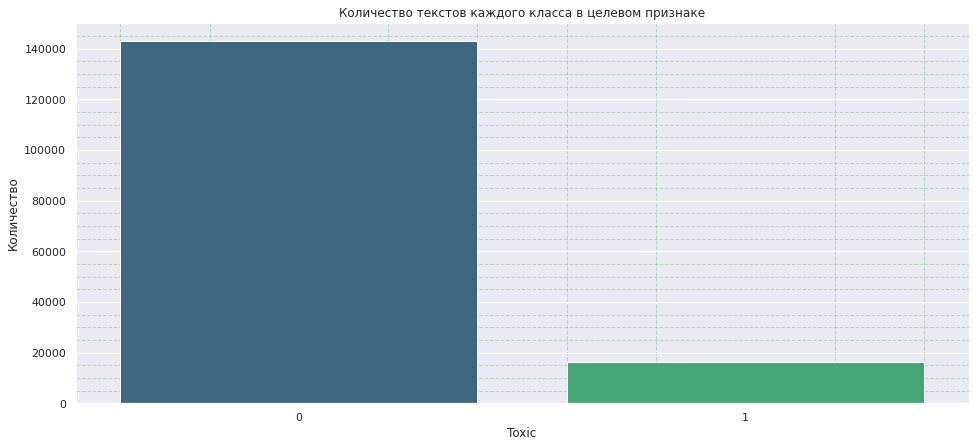

In [5]:
# Строим график, который покажет количество текстов каждого класса
plt.figure(figsize=(16,7))
sns.countplot(x=comments['toxic'], data=comments, palette='viridis')
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.title('Количество текстов каждого класса в целевом признаке')
plt.xlabel('Toxic')
plt.ylabel('Количество')
plt.show()

Мы видим, что баланс смещен в сторону текстов класса "0", что нужно учитывать в дальнейшем обучении модели.

### Количество символов в текстах

Сравним количество символов в текстах разной тональности.

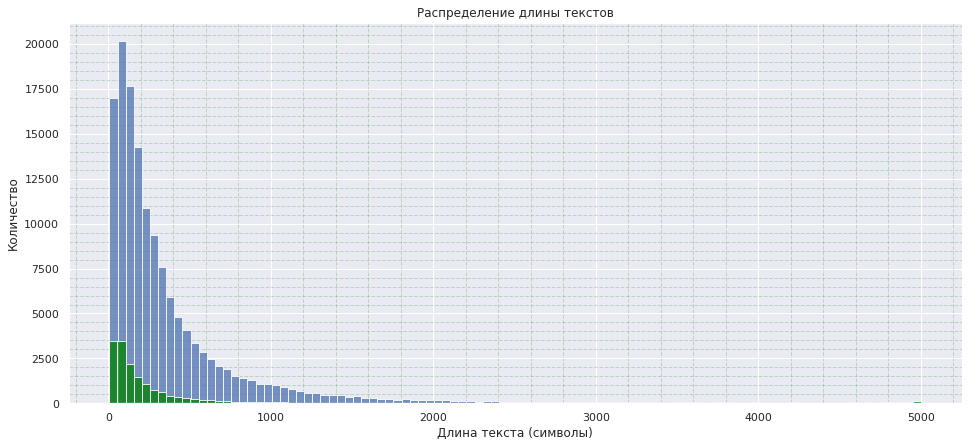

In [6]:
# Получаем длины текстов
text_lengths_0 = [len(text) for text in comments[comments['toxic'] == 0]['text'].values]
text_lengths_1 = [len(text) for text in comments[comments['toxic'] == 1]['text'].values]

# Строим гистограмму количества символов в тексте
plt.figure(figsize=(16,7))
sns.histplot(text_lengths_0, bins=100)
sns.histplot(text_lengths_1, bins=100, color='green')
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество')
plt.show()

Самые часто встречающиеся длины текстов и в негативном и в позитивном тексте находятся в пределах 200, характер распределений несильно отличается, заметна разница в количестве текстов.

**Вывод:** таким образом, мы провели исследовательский анализ данных и выяснили, что в целевой переменной присутствует дисбаланс классов, а распределения длин текстов похожи.

## **Подготовка данных**
<a id='preprocessing'></a>

### Лемматизация

Лемматизируем текст для дальнейшей работы.

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Функция для лемматизации 
def lemmatize_series(texts):
    lemmatized = []
    for doc in nlp.pipe(texts, batch_size=1000):
        lemmatized.append(" ".join(token.lemma_ for token in doc))
    return lemmatized

# Оставляем только латинские символы и пробелы
def clear_text(text):
    res = re.sub(r"[^a-zA-Z' ]", " ", text)
    return ' '.join(res.split())

In [8]:
# Лемматизируем текст и записываем в новый столбец
comments['lemm_text'] = lemmatize_series(comments['text'].progress_apply(clear_text))

  0%|          | 0/159292 [00:00<?, ?it/s]

### Разбиение на тестовую и тренировочную выборки

Разобьем наш датасет на тренировочную и тестовую выборки в соотношении 50:50.

In [9]:
X, y = comments['lemm_text'].fillna(""), comments['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

**Вывод:** таким образом, мы разбили тексты на леммы, разбили датасет на тренировочную и тестовую выборки.

## **Обучение модели**
<a id='model'></a>

Напишем пайплайн с предобработкой данных и обучением модели.

В качестве метрики возьмем F1, так как имеем дело с бинарной классификацией. 

In [10]:
pipe = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2), stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(class_weight='balanced', random_state=RANDOM_STATE))
])
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1')

In [11]:
print ('Метрика модели на кросс-валидации:', scores.mean())

Метрика модели на кросс-валидации: 0.7860610780610793


In [12]:
# Считаем предсказания модели
pipe.fit(X_train,y_train)
y_preds = pipe.predict(X_test)

print('Метрика модели на тестовой выборке: ', f1_score(y_test, y_preds))

Метрика модели на тестовой выборке:  0.7868030098398611


Улучшим качество с помощью подбора порога.

In [13]:
tuned_pipe = TunedThresholdClassifierCV(
    estimator=pipe,
    scoring='f1'
)

tuned_scores = cross_val_score(tuned_pipe, X_train, y_train, cv=5, scoring='f1')

In [14]:
print ('Метрика улучшенной модели на кросс-валидации:', tuned_scores.mean())

Метрика улучшенной модели на кросс-валидации: 0.7856500413192837


In [15]:
# Считаем предсказания модели
tuned_pipe.fit(X_train,y_train)
y_tuned_preds = tuned_pipe.predict(X_test)

print('Метрика модели на тестовой выборке: ', f1_score(y_test, y_tuned_preds))

Метрика модели на тестовой выборке:  0.7867025365103766


### Анализ важности признаков.

Узнаем, какие слова являются наиболее важными для классификации с точки зрения модели.

In [16]:
# Извлекаем названия и коэффициенты признаков
feature_names = tuned_pipe.estimator_.named_steps['vect'].get_feature_names_out()
coef = tuned_pipe.estimator_.named_steps['clf'].coef_[0]

# Создаем итоговый датафрейм
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coef': coef
}).sort_values('coef', ascending=False)

print(feature_importance.head(10))

          feature       coef
463346       fuck  10.249778
551705      idiot   7.757260
1066369      shit   7.725499
464445    fucking   7.574481
1133629    stupid   7.070124
84181         ass   6.470991
1139274      suck   6.016457
85745     asshole   5.829009
132294      bitch   5.486755
158339   bullshit   5.340718


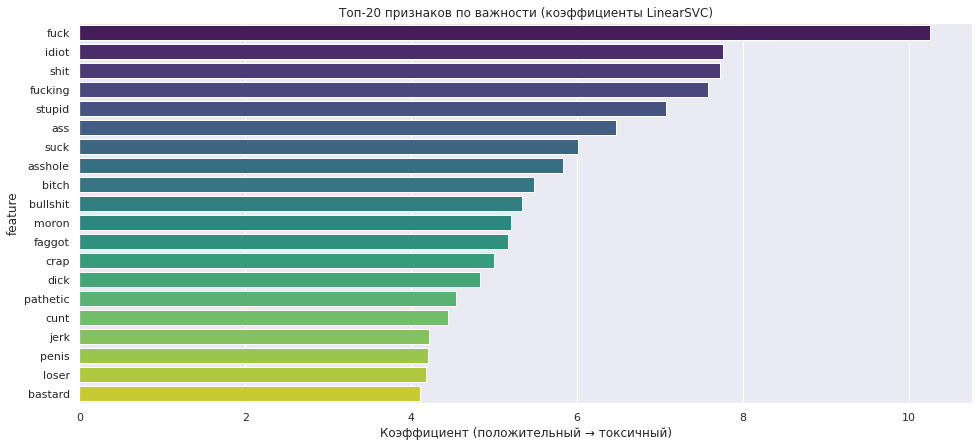

In [17]:
top_features = feature_importance.head(20)

plt.figure(figsize=(16, 7))
sns.barplot(x='coef',  y='feature', data=top_features, palette='viridis')
plt.title('Топ-20 признаков по важности (коэффициенты LinearSVC)')
plt.xlabel('Коэффициент (положительный → токсичный)')
plt.show()

Мы видим, что особое влияние на токсичность имеют бранные слова, что в принципе соответствует действительности.

**Вывод:** таким образом, мы обучили модель LinearSVС, которая дала  значение метрики f1 - 0.78, что не ниже порогового значения. А также проанализировали важность слов, которые имеют влияние при классификации.

### **Итоговые выводы**
<a id='final'></a>

Таким образом мы создали инструмент для интернет-магазина «Викишоп» :

1. Обучили модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75.

Для этого были выполнены следующие действия:

- **Открыт файл** с данными и изучена общая информация: 

**`/datasets/toxic_comments.csv`** содержал **159292 строки и 2 столбца**.


В данных пропуски отсутствовали, типы данных были корректны. Мы имели дело с текстами на английском языке.


- Выполнена **подготовка данных:**
    
    лемматизировали тексты и создали TF-IDF признаки этих текстов.


- Обучили модель:

    создали пайплайн для предобработки и обучения линейной модели опорных векторов

- Выбрали лучшую модель:

    **LinearSVC()**, f1 = 0.78 на тестовой выборке.
    
    
**Рекомендации для бизнеса:** 

Использовать TF-IDF для подготовки данных и биграммы, чтобы получить значение метрики f1 не меньше 0.75.

